you need to build the cmake and then the makefile in order to import the chess library!

In [1]:
import sys, pathlib
root = pathlib.Path.cwd().parents[0]
build = root / "build"
for p in (str(build), str(root)):
    if p not in sys.path: sys.path.insert(0, p)

import chess_py
import chess as pychess

print("C++ module at:", chess_py.__file__)
print("python-chess at:", pychess.__file__)

# Ensure we don't have duplicate loads of the C++ module
mods = [m for m in sys.modules if m == "chess_py" or m.endswith(".chess_py") or "chess_py" in m]
print("Modules containing 'chess_py':", mods)


C++ module at: /home/giovanni/Desktop/chess_RL/build/chess_py.cpython-312-x86_64-linux-gnu.so
python-chess at: /home/giovanni/Desktop/chess_RL/.venv/lib/python3.12/site-packages/chess/__init__.py
Modules containing 'chess_py': ['chess_py']


In [3]:
# import matplotlib.pyplot as plt

# import sys
# sys.path.insert(0, "../")
# from build import chess_py as chess
# from utils.plot_chess import plot_game
# # from utils.opponent_move import TwoPlyEnv, LichessDefender

# all'inizio del notebook (prima di qualunque import)
import sys, pathlib
root = pathlib.Path.cwd().parents[0]  # project root se notebook sta in doc/
build = root / "build"
utils = root / "utils"
for p in (str(build), str(root), str(utils)):
    if p not in sys.path: sys.path.insert(0, p)

import chess_py
from utils.opponent_move import TwoPlyEnv, LichessDefender  # wrapper
from utils.plot_chess import plot_game                      # usa python-chess
import matplotlib.pyplot as plt


## `Game` and `Move` classes

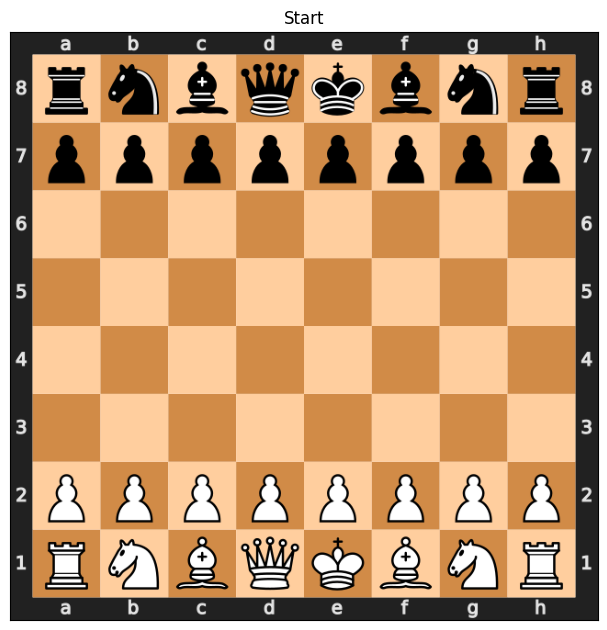

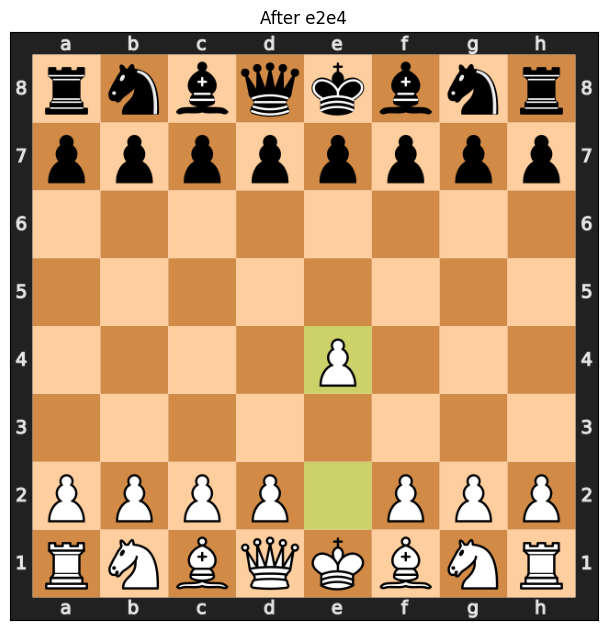

In [4]:
g = chess_py.Game()
g.reset_from_fen("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")
plot_game(
    g, 
    title="Start",
    coordinates=True
    )
plt.show()

# Make a move and re-plot
m = g.parse_move("e2","e4")  # or chess.Move.from_strings(g, "e2","e4") if you added that helper
g.do_move(m)
plot_game(
    g,
    # save_path="output/plots/turn_0.png",
    title="After e2e4",
    flipped=False,
    coordinates=True,
    lastmove="e2e4",    # opzionale: evidenzia l'ultima mossa
    # arrows=["g1f3"],    # opzionale: frecce
    # squares=["e4","d5"] # opzionale: evidenzia case
)
plt.show()

two ways to parse a move

In [5]:
g = chess_py.Game()
m1 = chess_py.Move.from_strings(g, "g1", "f3")

g.do_move(m1)
print(g.to_fen())

m2 = chess_py.Move.from_uci(g, "b8c6")
g.do_move(m2)
print(g.to_fen())

rnbqkbnr/pppppppp/8/8/8/5N2/PPPPPPPP/RNBQKB1R b KQkq - 0 1
r1bqkbnr/pppppppp/2n5/8/8/5N2/PPPPPPPP/RNBQKB1R w KQkq - 0 1


## `Env` class

The `Env` class represents the RL's environment. It contains the state, emits the reward, is able to evolve.

In [6]:
# Create a new game
game = chess_py.Game()

# Create Env (gamma=1.0, step_penalty=0.0 for default behavior)
env = chess_py.Env(game, gamma=0.99, step_penalty=0.01)

# Display initial state
print(env)  # uses __str__ from Env

Current FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
Current Board:
8 r n b q k b n r 
7 p p p p p p p p 
6                 
5                 
4                 
3                 
2 P P P P P P P P 
1 R N B Q K B N R 
  a b c d e f g h


Side to move: White
Is Game Over: No
Current Ply: 0



`env.state()` returns the state info (see `/include/environment.hpp`)

In [7]:
env.state()

<Game fen="rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1">

to make the env evolve (in the RL sense) we use the `.step(Move)` function. The move argument is the action that the agent makes and the environment evolves according to the chess rules (if the passed move is valid). The `.step` functions returns the pair: reward, a bool that indicates if it is the terminal state or not (i.e. checkmate)

In [8]:
env = chess_py.Env(game, gamma=0.99, step_penalty=0.01)
mv = chess_py.Move.from_strings(env.state(), "e2", "e4")  # env.state() returns Game
step = env.step(mv)
print(env)


Current FEN: rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1
Current Board:
8 r n b q k b n r 
7 p p p p p p p p 
6                 
5                 
4         P       
3                 
2 P P P P   P P P 
1 R N B Q K B N R 
  a b c d e f g h


Side to move: Black
Is Game Over: No
Current Ply: 1



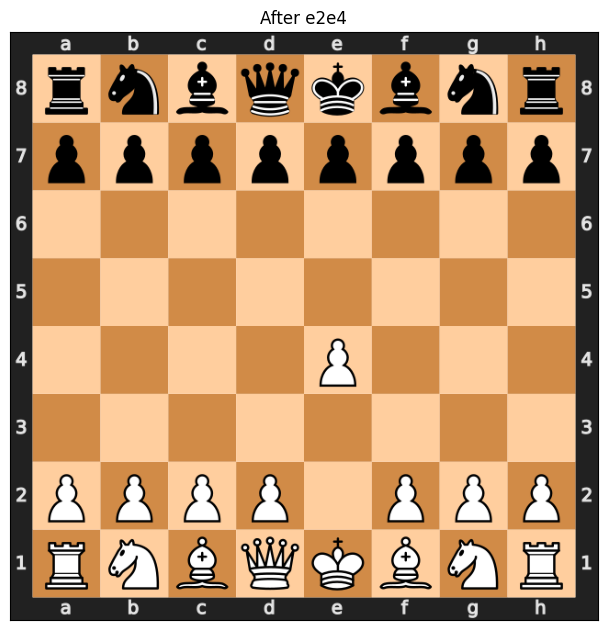

In [9]:
plot_game(env.state(), title="After e2e4")
plt.show()

In [10]:

print(step.reward, step.done)

-0.01 False


Nice website to build position and return FEN: https://www.redhotpawn.com/chess/chess-fen-viewer.php

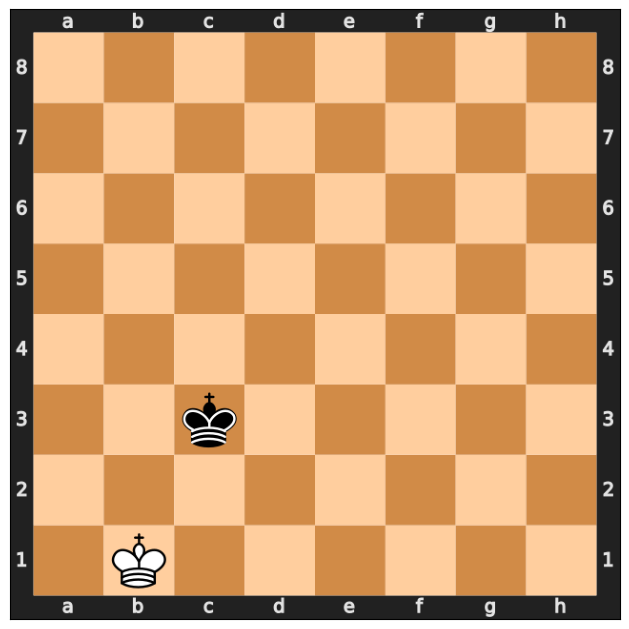

In [11]:
# env constructor from fen

env = chess_py.Env("8/8/8/8/8/2k5/8/1K6 w - - 0 1", gamma=0.99, step_penalty=0.01)
plot_game(env.state())
plt.show()

In [12]:
# write demo of count pieces

env.is_terminal()

True

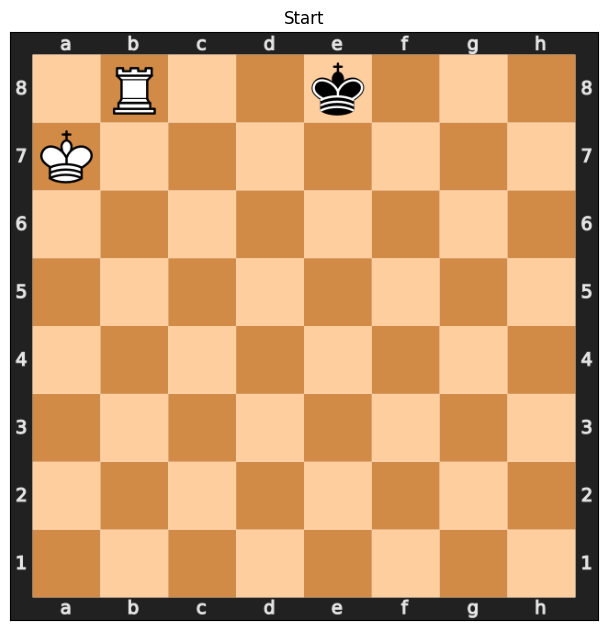

In [13]:
g = chess_py.Game()
g.reset_from_fen("1R2k3/K7/8/8/8/8/8/8 b - - 0 1")
plot_game(g, title="Start")
plt.show()

In [14]:
moves = g.legal_moves(chess_py.BLACK)
for m in moves:
    print(chess_py.Move.to_uci(m))

e8d7
e8e7
e8f7


In [15]:
env_cpp = chess_py.Env("1R2k3/K7/8/8/8/8/8/8 w - - 1 0", 1.0, 0.0)
env_cpp


Current FEN: 1R2k3/K7/8/8/8/8/8/8 w - - 0 1
Current Board:
8   R     k       
7 K               
6                 
5                 
4                 
3                 
2                 
1                 
  a b c d e f g h


Side to move: White
Is Game Over: No
Current Ply: 0

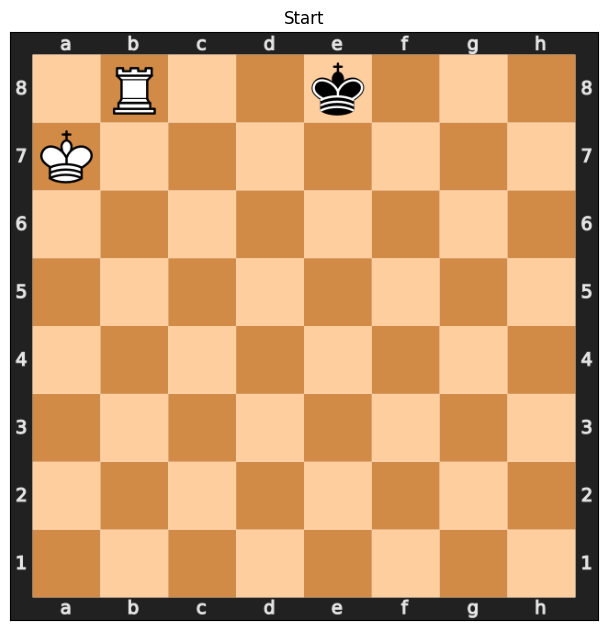

In [16]:
env = TwoPlyEnv(env_cpp, defender=LichessDefender())   # or SyzygyDefender("/path/to/tb")

plot_game(env.env.state(), title="Start")
plt.show()


In [17]:
moves = env.env.state().legal_moves(chess_py.BLACK)
for m in moves:
    print(chess_py.Move.to_uci(m))

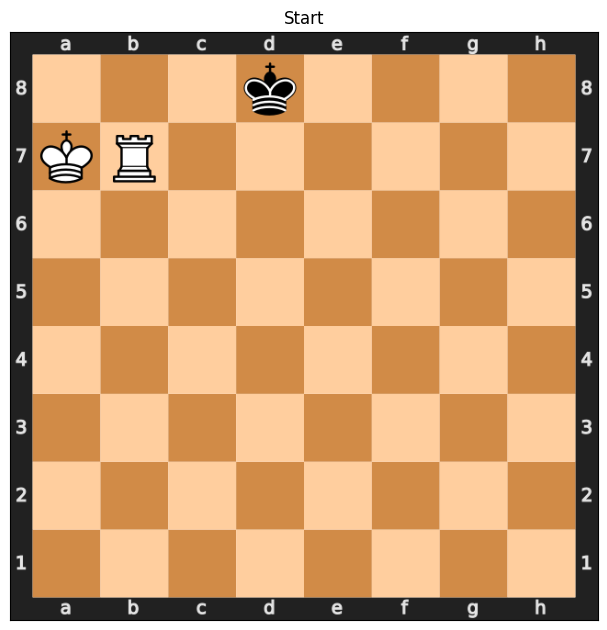

In [18]:

white_uci = "b8b7"  # example
sr = env.step(white_uci)
plot_game(env.env.state(), title="Start")
plt.show()


In [19]:

sr.reward # is a composed reward; 
sr.done #tells you if the episode ended

False

## Python env

In [20]:
from utils.env_class import Env, LichessDefender

env = Env.from_fen(
    "8/8/8/8/8/8/4k3/4K3 w - - 0 1",
    step_penalty=0.01,
    defender=LichessDefender(),   # or SyzygyDefender("/path/to/tables")
)


In [21]:

r = env.step("e1e2")  # agent plays by UCI



In [22]:
print(r)


StepResult(reward=-1000.0, done=True, info={'absorbed_reply': False, 'reply_uci': None})


In [23]:
print(env.to_string())


Current FEN: 8/8/8/8/8/8/4K3/8 b - - 0 1
Current Board:
(board print unavailable)
Side to move: Black
Is Game Over: Yes
Current Ply: 1



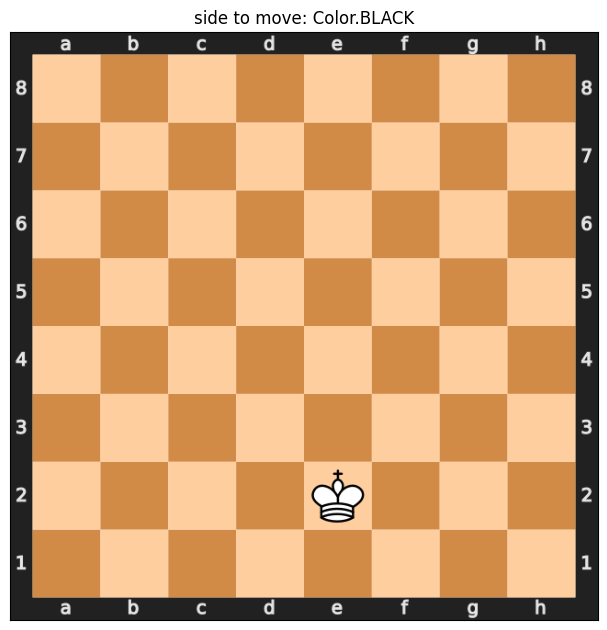

In [24]:
env.display_state()

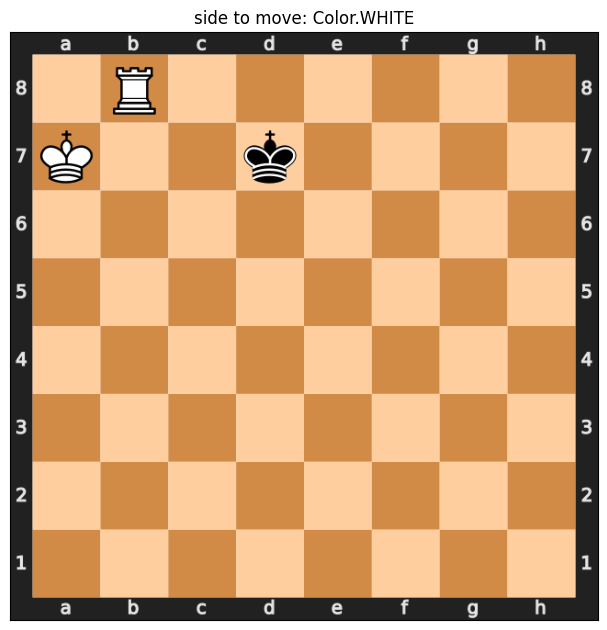

In [25]:
fen = "1R6/K2k4/8/8/8/8/8/8 w - - 1 0"
env = Env.from_fen(
    fen,
    step_penalty=0.01,
    defender=LichessDefender(),    # auto-reply using Lichess tablebase
    absorb_black_reply=True
)
env.display_state()


In [26]:

# 2. White plays a move (UCI or Move object)
agent_move = "b8b7"
result = env.step(agent_move)



Step result: StepResult(reward=-0.01, done=False, info={'absorbed_reply': True, 'reply_uci': 'd7c6'})
Current FEN: 8/KR6/2k5/8/8/8/8/8 w - - 0 1
Current Board:
(board print unavailable)
Side to move: White
Is Game Over: No
Current Ply: 2



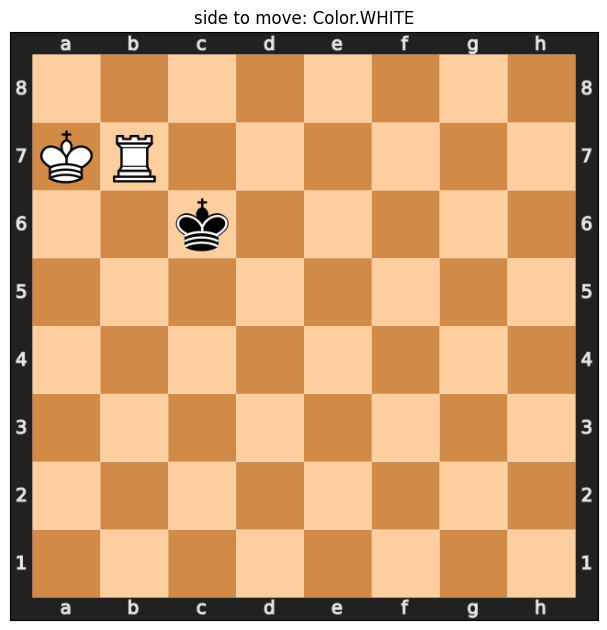

In [27]:

# 3. Print outcome and environment info
print("Step result:", result)
print(env.to_string())
env.display_state()

In [28]:
import chess_py as cp

g = env.state()
stm = g.get_side_to_move()
print("Side to move:", "BLACK" if stm == cp.Color.BLACK else "WHITE")
print("in_check(BLACK):", g.get_check(cp.Color.BLACK) if hasattr(g, "get_check") else g.in_check())
print("is_checkmate:", g.is_checkmate())
print("is_stalemate:", g.is_stalemate())

# Count legal replies for Black
moves = g.legal_moves(cp.Color.BLACK)
print("num legal moves for Black:", len(moves))
print("sample replies (up to 5):", [cp.Move.to_uci(m) for m in moves[:5]])

print("is_game_over():", g.is_game_over())

print("is insufficient material():", g.is_insufficient_material())


Side to move: WHITE
in_check(BLACK): False
is_checkmate: False
is_stalemate: False
num legal moves for Black: 0
sample replies (up to 5): []
is_game_over(): False
is insufficient material(): False
